In [1]:
# !pip install transformers
# !pip install -q torch torchvision torchaudio
# !pip install supabase
# !pip install dotenv

In [2]:
from google.colab import files,drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
import sys
sys.path.append('/gdrive/MyDrive/finn-project/be-ai-model')

from data_processing import get_csv_data, merge_data
from sentiment_model import analyze_sentiment_with_progress_for_training, add_integer_column, sums_sentiment_score_for_7_days, update_sentiment_score_in_db
from lstm_model import get_scale_data, get_scale_data_with_fit, create_sequences_for_train, compile_model, train_model, predict_prices, create_sequences_for_prod
from final_result import compare_prices_with_graph


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [4]:
import pandas as pd

news_train_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_news_train.csv")
news_test_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_news_test.csv")

news_train_df = analyze_sentiment_with_progress_for_training(news_train_df)
news_test_df = analyze_sentiment_with_progress_for_training(news_test_df)

감성 분석 진행중:   0%|          | 0/391 [00:00<?, ?batch/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


감성 분석 진행중:   0%|          | 0/224 [00:00<?, ?batch/s]

In [5]:
stock_train_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_prices_train.csv")
stock_test_df = get_csv_data("/gdrive/MyDrive/finn-project/tsla_prices_test.csv")

stock_train_df['date'] = pd.to_datetime(stock_train_df['date']).dt.strftime('%Y-%m-%d')
stock_test_df['date'] = pd.to_datetime(stock_test_df['date']).dt.strftime('%Y-%m-%d')

In [6]:
merged_train = merge_data(news_train_df, stock_train_df)
merged_test = merge_data(news_test_df, stock_test_df)

merged_train['sentiment_influence'] = 0.0
merged_test['sentiment_influence'] = 0.0

merged_train = add_integer_column(merged_train)
merged_test = add_integer_column(merged_test)

sums_sentiment_score_for_7_days(merged_train)
sums_sentiment_score_for_7_days(merged_test)

  0%|          | 0/12482 [00:00<?, ?it/s]

  0%|          | 0/7141 [00:00<?, ?it/s]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features = ['sentiment_influence', 'open', 'high', 'low', 'adjClose', 'volume']
target   = 'close'

merged_train = merged_train[ features + [target] ].dropna()
merged_test  = merged_test[ features + [target] ].dropna()

train_scaled = get_scale_data_with_fit(scaler, merged_train)
test_scaled = get_scale_data(scaler, merged_test)

X_train, y_train = create_sequences_for_train(train_scaled)
X_test, y_test = create_sequences_for_train(test_scaled)

In [ ]:
merged_train

In [ ]:
merged_test

In [8]:
from tensorflow.keras.models import load_model

def get_existing_model(path):
  load_path = '/gdrive/MyDrive/finn-project/models/finn_model.h5'
  return load_model(load_path)

In [9]:
model = compile_model(X_train)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model = train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0035 - val_loss: 3.6229e-04
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.9709e-05 - val_loss: 3.8009e-04
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.5586e-05 - val_loss: 2.4551e-04
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.7185e-05 - val_loss: 1.6275e-04
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.3601e-05 - val_loss: 2.2220e-04
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.3719e-05 - val_loss: 1.8367e-04
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.9367e-05 - val_loss: 1.1166e-04
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.4953e-05 - val_loss: 1.0041e-04
Epoch 9/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.1308e-05 - val_loss: 1.4082e-04
Epoch 10/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.0604e-05 - val_loss: 7.1973e-05
Epoch 11/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.

In [11]:
y_pred_scaled = predict_prices(model, X_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [13]:
import numpy as np

features = ['sentiment_influence', 'open', 'high', 'low', 'adjClose', 'volume']
target   = 'close'
all_cols = features + [target]
target_col_index = all_cols.index(target)

num_features = len(features)
dummy_array = np.zeros((len(y_pred_scaled), len(all_cols)))
# 'close' 위치(6번 인덱스)에 예측된 값을 삽입
dummy_array[:, target_col_index] = y_pred_scaled.ravel()
# Scaler를 이용해 전체 배열을 역변환하고, 'close' 컬럼만 추출
y_pred_actual = scaler.inverse_transform(dummy_array)[:, target_col_index]

# y_test도 역변환
dummy_array_test = np.zeros((len(y_test), len(all_cols)))
dummy_array_test[:, target_col_index] = y_test.ravel()
y_test_actual = scaler.inverse_transform(dummy_array_test)[:, target_col_index]

In [14]:
# 이제 y_pred는 실제 주가 스케일의 예측값입니다.
next_day_predicted_close = y_pred_actual[-1]
print(f"예측된 실제 종가: ${next_day_predicted_close:.4f}")

예측된 실제 종가: $348.1769


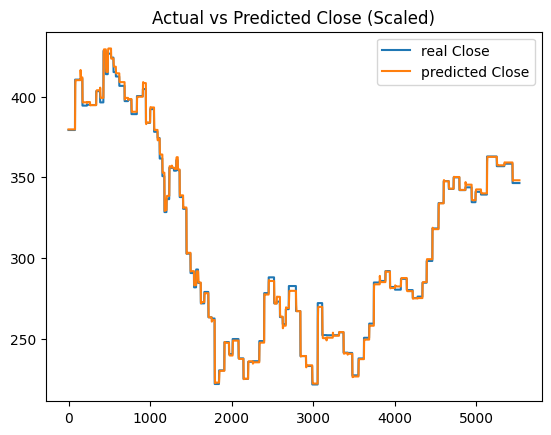

In [15]:
compare_prices_with_graph(y_test_actual, y_pred_actual)

In [18]:
save_path = '/gdrive/MyDrive/finn-project/models/tsla_finn_model.keras'
model.save(save_path)

import pickle
scaler_path = '/gdrive/MyDrive/finn-project/models/tsla_finn_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)